In [2]:
import numpy as np
import os
from mrcnn.utils import Dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import matplotlib.pyplot as plt
import sys
import random
from mrcnn.model import log
from mrcnn import visualize
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
MODEL_DIR = 'logs'
import mrcnn.model as modellib
import cv2

Using TensorFlow backend.


In [3]:

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class PredictionConfig(Config):
    NAME = "HRC"
    NUM_CLASSES = 1 + 6
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    #BATCH_SIZE = 256


cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=cfg)

WEIGHT_DIR = R"C:\Users\HPDQ\Mask_RCNN\logs\steel20211020T1655\mask_rcnn_steel_0050.h5"
model.load_weights(WEIGHT_DIR, by_name=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.






Re-starting from epoch 50


In [9]:
#image_id = random.choice(test_set.image_ids)
#original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#    modellib.load_image_gt(test_set, PredictionConfig, 
#                           image_id, use_mini_mask=False)

#log("original_image", original_image)
#log("image_meta", image_meta)
#log("gt_class_id", gt_class_id)
#log("gt_bbox", gt_bbox)
#log("gt_mask", gt_mask)

#visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                            train_set.class_names, figsize=(8, 8))


(256, 256, 3)


In [13]:
class SteelDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        #self.add_class("dataset", 0, "BG")
        self.add_class("dataset", 1, "crazing")
        self.add_class("dataset", 2, "inclusion")
        self.add_class("dataset", 3, "pathches")
        self.add_class("dataset", 4, "pitted_surface")
        self.add_class("dataset", 5, "rolled-in_scale")
        self.add_class("dataset", 6, "scratches")
        # define data locations
        images_dir = dataset_dir + '/IMAGES/'
        annotations_dir = dataset_dir + '/ANNOTATIONS/'
        count = 0
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = count
            # skip all images after 150 if we are building the train set

            img_path = images_dir + filename
            
            _ann_path = filename.replace(".jpg", "")
            ann_path = annotations_dir + _ann_path + '.xml'
            
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path, class_ids=[0,1,2,3,4,5,6])
            count = count + 1
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()

        for box in root.findall('.//object'):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            if name=='crazing' or name=='inclusion' or name=='patches' or name=='pitted_surface' or name=='rolled-in_scale' or name=='scratches':
                boxes.append(coors)

        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height 
# load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if (box[4] == 'crazing'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('crazing'))
            elif(box[4] == "inclusion"):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('inclusion'))
            elif(box[4] == "patches"):
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('pathches')) 
            elif(box[4] == "pitted_surface"):
                masks[row_s:row_e, col_s:col_e, i] = 4
                class_ids.append(self.class_names.index('pitted_surface')) 
            elif(box[4] == "rolled-in_scale"):
                masks[row_s:row_e, col_s:col_e, i] = 5
                class_ids.append(self.class_names.index('rolled-in_scale'))
            elif(box[4] == "scratches"):
                masks[row_s:row_e, col_s:col_e, i] = 6
                class_ids.append(self.class_names.index('scratches'))  
        return masks, asarray(class_ids, dtype='int32')

In [14]:
test_set = SteelDataset()
dataset_test_dir = r"C:\Users\HPDQ\Mask_RCNN\DATASET\neuDatasetIsTest"
test_set.load_dataset(dataset_test_dir, is_train=True)
test_set.prepare()
print('Train: %d' % len(test_set.image_ids))

Train: 360


(256, 256, 3)
Processing 1 images
image                    shape: (256, 256, 3)         min:   32.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -91.70000  max:  150.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


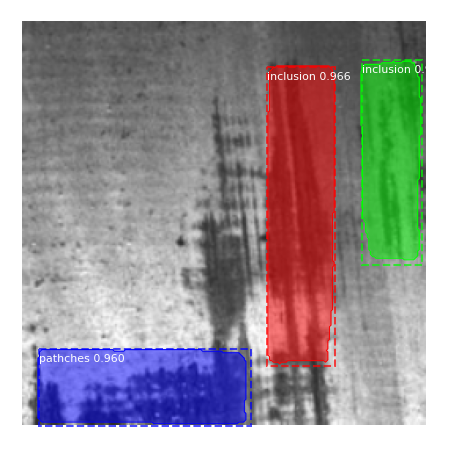

In [27]:
path = r"C:\Users\HPDQ\Mask_RCNN\DATASET\QUANGRESIZE200x200\H5.jpg"
original_image = cv2.imread(path)
dsize = (256, 256)
original_image = cv2.resize(original_image, dsize)
print (original_image.shape)
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], ax=get_ax())